Import needed stuff

In [1]:
import requests
import pandas as pd
import numpy as np
from scipy import sparse
from io import StringIO
from matplotlib import pyplot as plt
import seaborn as sns
import networkscience as ns
import pycountry as pc

Downloading data by http request

In [2]:
# reply = requests.get('https://data.europa.eu/euodp/data/storage/f/2020-08-11T140550/Finalised%20mobilities%20started%20in%202018%20-%20KA1.csv')
# reply.encoding = 'utf-8'
# csv_data = reply.text
# df = pd.read_csv(StringIO(csv_data), sep=';',low_memory=False)
country_df = pd.read_csv('erasmus_data_clean.csv', sep=';',low_memory=False, header=0)

## Mobility of Countries
In this section we want to analyze how musch different countries are involved in the Erasmus program.

I am not sure there are enought node to have a sensible analysis of the problem.

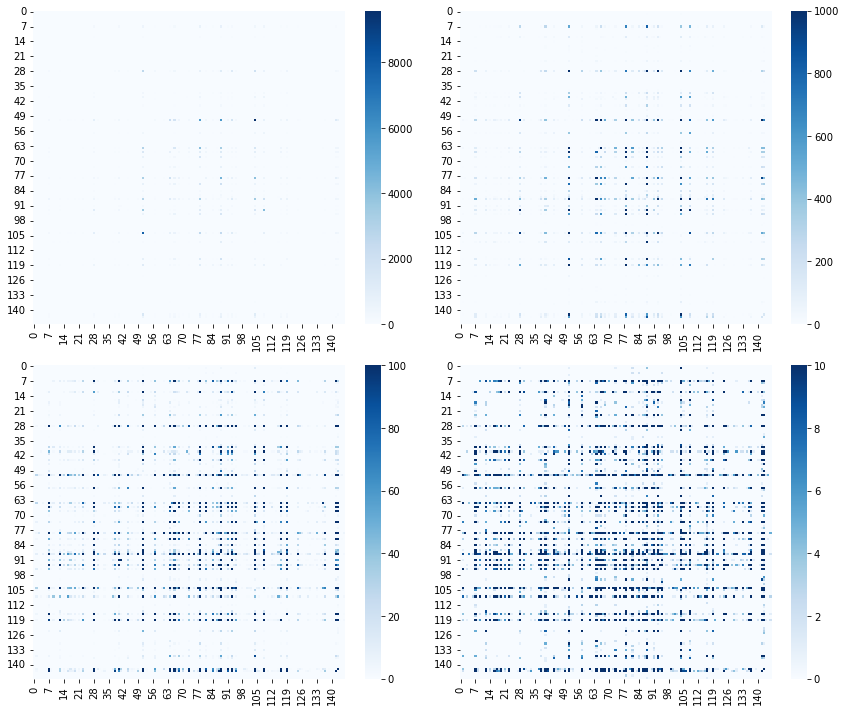

In [3]:
#country_df = df[df[df.columns[10]]=='Learner']
#country_df = country_df.loc[:, df.columns[np.array((14, 17, 20))]]
#country_df.dropna(how='any', inplace=True)
# nodes = np.array(list(set.union(set(country_df.loc[:, country_df.columns[0]]), set(country_df.loc[:, country_df.columns[1]]))))
nodes = np.array(list(set.union(set(country_df.loc[:, country_df.columns[4]]), set(country_df.loc[:, country_df.columns[5]]))))
country_df.dropna(how='any', inplace=True)
# I don't want it to take forever
node_position = {}
for i, name in enumerate(nodes):
    node_position[name] = i
nodes_df = pd.DataFrame({'Nodes': nodes})
country_df['SendId'] = (np.array(list(map(lambda x: node_position[x], country_df['Sending Country Code']))))
country_df['RecId']= (np.array(list(map(lambda x: node_position[x], country_df['Receiving Country Code']))))
# Adjacency matrix
country_serie = country_df.groupby(['SendId', 'RecId']).sum()
row = np.array(country_serie.index.get_level_values(1).tolist())
col = np.array(country_serie.index.get_level_values(0).tolist())
val = country_serie.values
adj_matrix_crs = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))

def replace_iso3166(alpha):
    try:
        return pc.countries.get(alpha_2=alpha).name
    except:
        return alpha

country_df['Receiving Country Code']= (np.array(list(map(lambda x: replace_iso3166(x), country_df['Receiving Country Code']))))
country_df['Sending Country Code']= (np.array(list(map(lambda x: replace_iso3166(x), country_df['Sending Country Code']))))
nodes_df['Nodes'] = (np.array(list(map(lambda x: replace_iso3166(x), nodes_df['Nodes']))))

ns.visualize_adj(adj_matrix_crs)

I would like to understand if the corresponent undirected unwiegthed graph was symmetric, but it is not

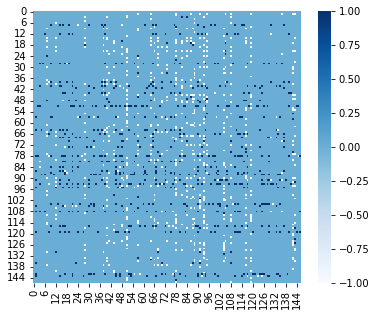

In [4]:
matr = adj_matrix_crs.toarray()
matr[matr>1]=1
matr = matr - matr.T
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(matr, cmap="Blues", ax=ax)
plt.show()


Calculation of the number of components in the network

In [5]:
country_df.rename({'Sending Country Code': 'source', 'Receiving Country Code':'target', 'Participants':'weight'},axis=1, inplace=True)
components = ns.find_components(adj_matrix_crs, nodes_df)
unique, counts = np.unique(components['component'], return_counts=True)
print('Number of components =', len(unique))

Number of components = 2


### Degree distribution

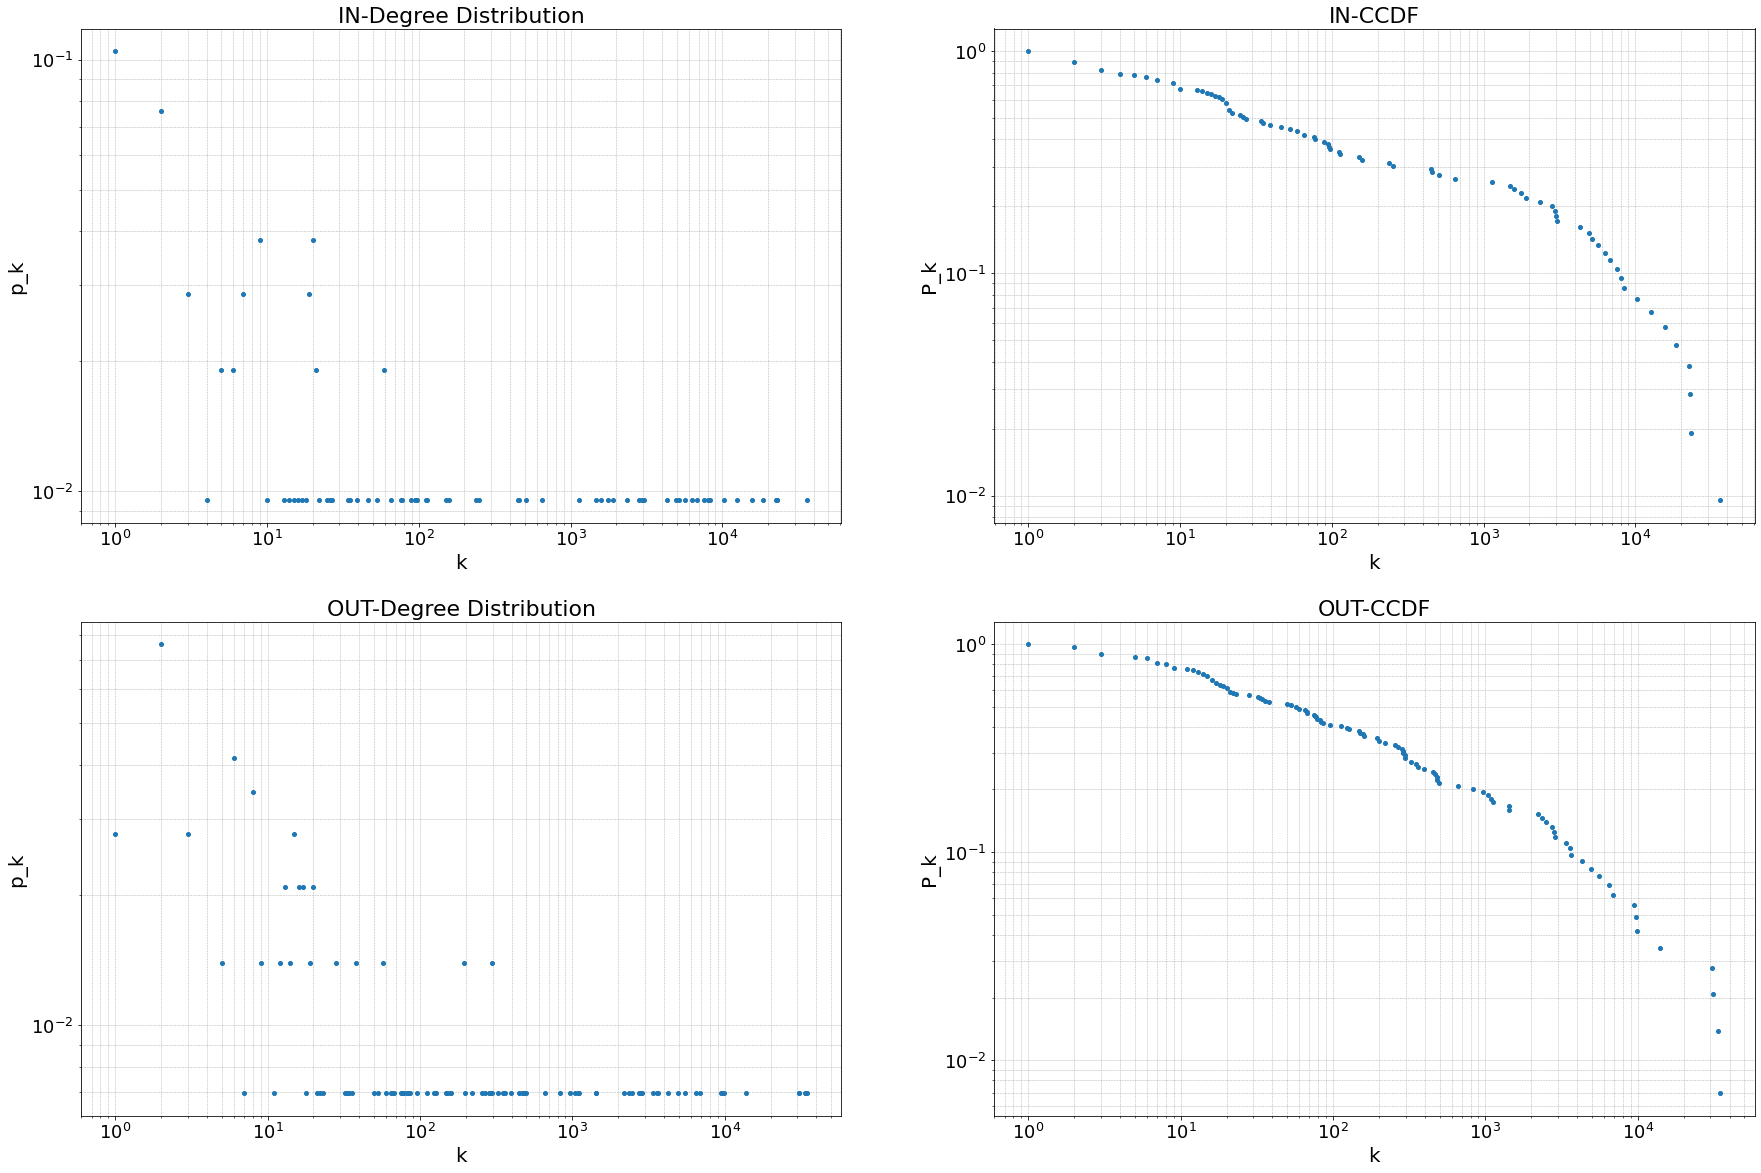

Top 10 for in degree


,Nodes,in degree
51,Spain,36061
78,France,23076
88,Germany,22881
104,Italy,22656
64,UK,18489
93,Poland,15588
28,Portugal,12579
66,Netherlands,10212
119,Czechia,8353
81,Sweden,8069


Top 10 for out degree


,Nodes,out degree
51,Spain,34644
88,Germany,33750
104,Italy,30946
78,France,30586
108,Turkey,13897
66,Netherlands,9824
93,Poland,9781
64,UK,9398
28,Portugal,6864
142,Belgium,6498


In [6]:
scores = ns.degree_disribution(adj_matrix_crs, nodes_df, print_graph=True)
ns.display_top_n(scores, 10, 'in degree')
ns.display_top_n(scores, 10, 'out degree')

### HITS (NetworkX)

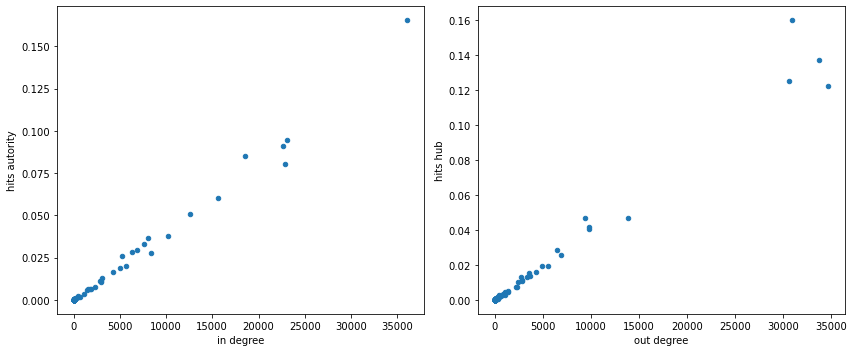

Top 10 for hits hub


,Nodes,hits hub
104,Italy,0.159838
88,Germany,0.137307
78,France,0.124933
51,Spain,0.122427
64,UK,0.046543
108,Turkey,0.046529
66,Netherlands,0.041817
93,Poland,0.040711
142,Belgium,0.028642
28,Portugal,0.025891


Top 10 for hits autority


,Nodes,hits autority
51,Spain,0.165365
78,France,0.094807
104,Italy,0.090851
64,UK,0.085194
88,Germany,0.080147
93,Poland,0.060180
28,Portugal,0.050619
66,Netherlands,0.037963
81,Sweden,0.036765
116,Finland,0.033226


In [7]:
df = ns.hits_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
scores = pd.merge(scores, df, on='Nodes')

ns.display_top_n(scores, 10, 'hits hub')
ns.display_top_n(scores, 10, 'hits autority')

### PageRank (NetworkX)

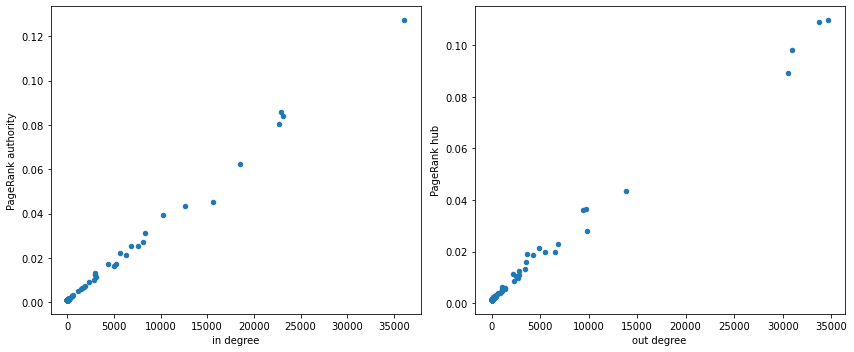

Top 10 for PageRank hub


,Nodes,PageRank hub
51,Spain,0.109555
88,Germany,0.108978
104,Italy,0.097891
78,France,0.089319
108,Turkey,0.043546
93,Poland,0.036413
64,UK,0.036291
66,Netherlands,0.027928
28,Portugal,0.023102
143,Austria,0.021601


Top 10 for PageRank authority


,Nodes,PageRank authority
51,Spain,0.127210
88,Germany,0.086031
78,France,0.084201
104,Italy,0.080548
64,UK,0.062429
93,Poland,0.045424
28,Portugal,0.043197
66,Netherlands,0.039129
119,Czechia,0.031233
81,Sweden,0.027290


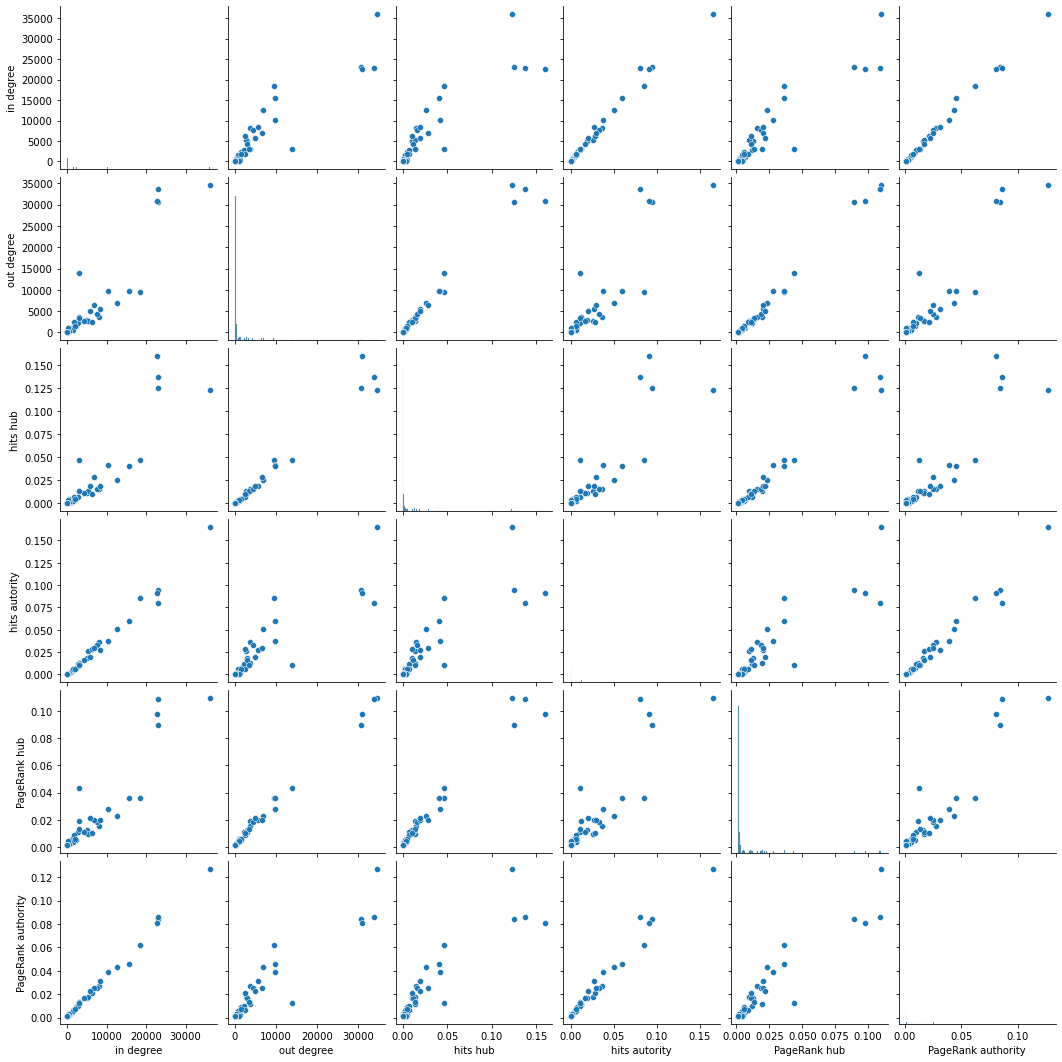

In [8]:
df = ns.pagerank_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
scores = pd.merge(scores, df, on='Nodes')

ns.display_top_n(scores, 10, 'PageRank hub')
ns.display_top_n(scores, 10, 'PageRank authority')

sns.pairplot(scores)
plt.show()

In [9]:
def create_position(score_df, label):
    scores = score_df.sort_values(label, ascending=False)
    scores[label+' position']= (np.arange(len(scores.index))+1)
    return scores

scores = create_position(scores, 'in degree')
scores = create_position(scores, 'out degree')
scores = create_position(scores, 'hits hub')
scores = create_position(scores, 'hits autority')
scores = create_position(scores, 'PageRank hub')
scores = create_position(scores, 'PageRank authority')
scores.sort_index(inplace=True)

In [10]:
n = 40
pd.set_option('display.max_rows', n)
display(scores.sort_values('PageRank authority', ascending=False)[['Nodes', 'in degree', 'in degree position', 'hits autority', 'hits autority position', 'PageRank authority', 'PageRank authority position']].head(n))
display(scores.sort_values('PageRank hub', ascending=False)[['Nodes', 'out degree', 'out degree position', 'hits hub', 'hits hub position', 'PageRank hub', 'PageRank hub position']].head(n))

,Nodes,in degree,in degree position,hits autority,hits autority position,PageRank authority,PageRank authority position
51,Spain,36061,1,0.165365,1,0.127210,1
88,Germany,22881,3,0.080147,5,0.086031,2
78,France,23076,2,0.094807,2,0.084201,3
104,Italy,22656,4,0.090851,3,0.080548,4
64,UK,18489,5,0.085194,4,0.062429,5
93,Poland,15588,6,0.060180,6,0.045424,6
28,Portugal,12579,7,0.050619,7,0.043197,7
66,Netherlands,10212,8,0.037963,8,0.039129,8
119,Czechia,8353,9,0.027589,13,0.031233,9
81,Sweden,8069,10,0.036765,9,0.027290,10


,Nodes,out degree,out degree position,hits hub,hits hub position,PageRank hub,PageRank hub position
51,Spain,34644,1,0.122427,4,0.109555,1
88,Germany,33750,2,0.137307,2,0.108978,2
104,Italy,30946,3,0.159838,1,0.097891,3
78,France,30586,4,0.124933,3,0.089319,4
108,Turkey,13897,5,0.046529,6,0.043546,5
93,Poland,9781,7,0.040711,8,0.036413,6
64,UK,9398,8,0.046543,5,0.036291,7
66,Netherlands,9824,6,0.041817,7,0.027928,8
28,Portugal,6864,9,0.025891,10,0.023102,9
143,Austria,4930,12,0.019139,12,0.021601,10


### Assortativity
We have to check if this disassortativity is due to structural reason, because it looks weird. It is almost the opposit of what we saw for the complete network.

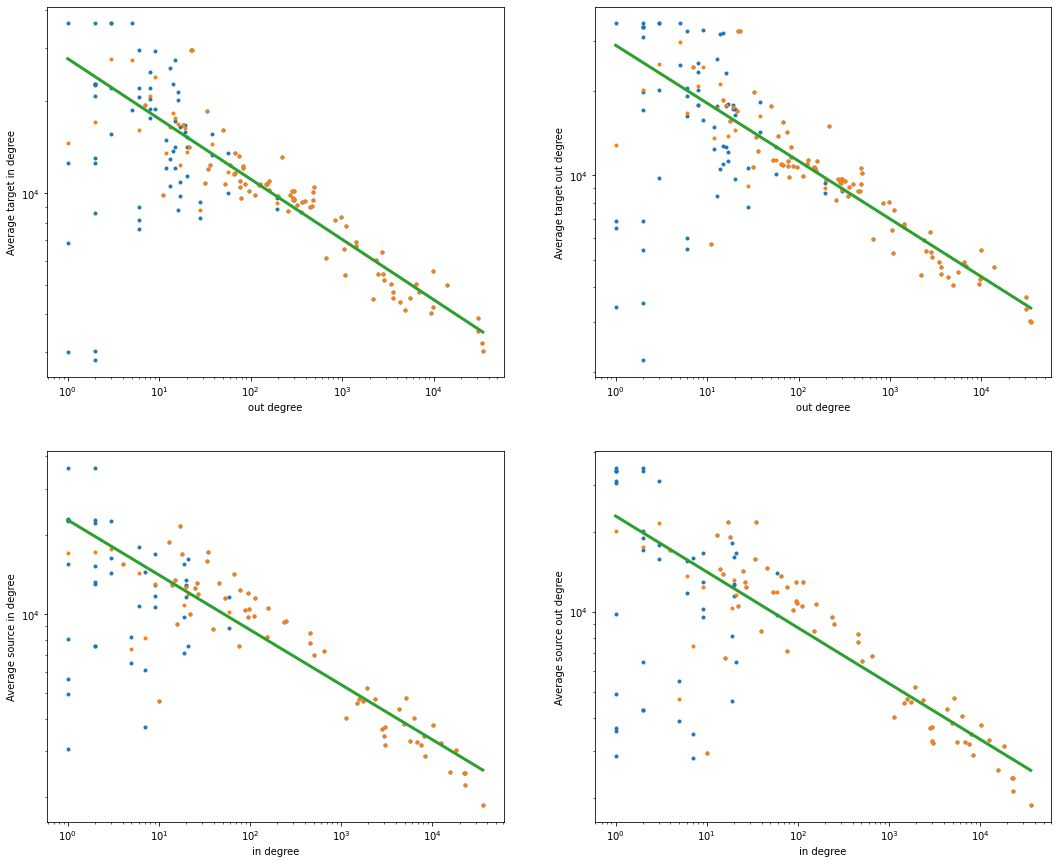

(-0.19762392162556142,
 -0.20560451452382256,
 -0.20933480935164436,
 -0.20970160450386402)

In [11]:
edges = country_df[['source','target']].copy()
ns.assortativity_calc(edges, adj_matrix_crs, nodes_df, True)

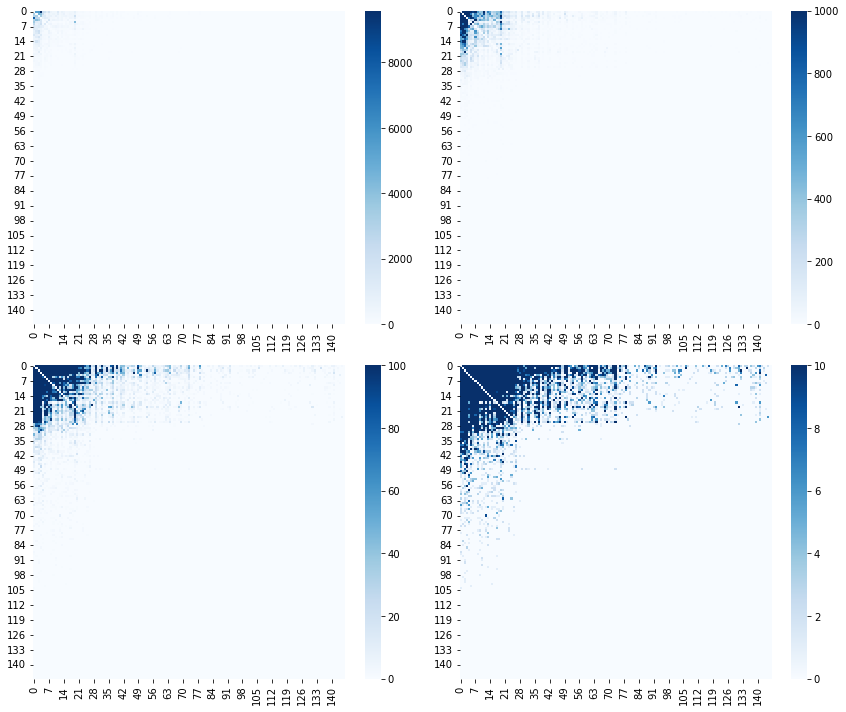

In [12]:
# label = 'PageRank autority position'
label = 'in degree position'
c = country_df.drop(['SendId', 'RecId'],axis=1)
another_order = scores[['Nodes', label]].copy()
another_order[label] = another_order[label] - 1
another_order.rename({'Nodes':'source', label: 'source ID'}, axis=1, inplace=True)
c = pd.merge(c, another_order, on="source")
another_order.rename({'source':'target', 'source ID': 'target ID'}, axis=1, inplace=True)
c = pd.merge(c, another_order, on="target")
c_serie = c.groupby(['source ID', 'target ID']).sum()
row = np.array(c_serie.index.get_level_values(1).tolist())
col = np.array(c_serie.index.get_level_values(0).tolist())
val = c_serie.values
or_adj = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))

ns.visualize_adj(or_adj)

The plot highlights differences between the adjacency matrix and the transpose one. It can explain disassortativity.

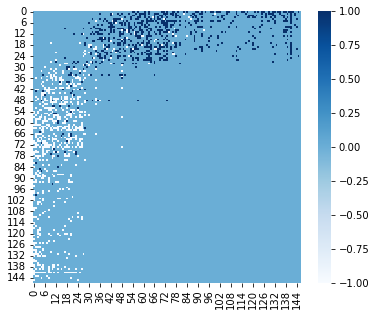

In [13]:
matr = or_adj.toarray()
matr[matr>1]=1
matr = matr - matr.T
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(matr, cmap="Blues", ax=ax)
plt.show()

This is only a draft version of community detection

In [14]:
import networkx as nx
# import community

G = nx.convert_matrix.from_scipy_sparse_matrix(adj_matrix_crs)
p = nx.algorithms.community.modularity_max.greedy_modularity_communities(G)
node_comm = nodes_df.copy()

node_comm['Community']=np.zeros(len(node_comm.index),dtype='int8')
for i, set in enumerate(p):
    for element in set:
        node_comm.iat[element, 1]=i
for i, set in enumerate(p):
    display(node_comm[node_comm['Community']==i])


,Nodes,Community
2,Haiti,0
4,Paraguay,0
8,Australia,0
11,Gabon,0
13,Mozambique,0
...,...,...
128,Ethiopia,0
131,Singapore,0
140,Dominican Republic,0
143,Austria,0


,Nodes,Community
1,"Palestine, State of",1
7,Hungary,1
9,Azerbaijan,1
10,Gambia,1
16,Bosnia and Herzegovina,1
...,...,...
129,Malaysia,1
133,Lebanon,1
134,"Tanzania, United Republic of",1
136,Malta,1


,Nodes,Community
3,Sri Lanka,2
5,Timor-Leste,2
6,Sudan,2
12,Bulgaria,2
14,Belarus,2
...,...,...
139,"Congo, The Democratic Republic of the",2
141,Panama,2
142,Belgium,2
144,Papua New Guinea,2


,Nodes,Community
0,nan,3


## Geographic Heat map 

In [15]:
import geopandas as gpd

geo_df = gpd.read_file('countries.geojson')

def replace_iso2(alpha):
    try:
        return pc.countries.get(alpha_3=alpha).alpha_2
    except:
        return alpha
    
geo_df['iso2_code']= (np.array(list(map(lambda x: replace_iso2(x), geo_df['ISO_A3']))))

geo_df.columns = ['country', 'country_code', 'geometry', 'iso2_code']

In [16]:
# adding code country to scores dataframe
countries_codes = nodes_df
countries_codes['code'] = nodes
scores_merge = pd.merge(left=countries_codes, right=scores, how='right', left_on='Nodes', right_on='Nodes')

# in geo_df United Kingdom has code GB, so we have to change it manually
geo_df.loc[geo_df['country'] == 'United Kingdom', 'iso2_code'] = 'UK'
geo_df.loc[geo_df['country'] == 'Greece', 'iso2_code'] = 'EL'
geo_df.loc[geo_df['country'] == 'Kosovo', 'iso2_code'] = 'XK'
geo_df.loc[geo_df['country'] == 'Czech Republic', 'country'] = 'Czechia'
geo_df.loc[geo_df['country'] == 'Republic of Serbia', 'country'] = 'Serbia'

# adding Switzerland since there is no Erasmus data
sw = {'Nodes':'Switzerland', 'code':'CH', 'in degree':0, 'out degree':0, 'hits hub':0, 'hits autority':0,
       'PageRank hub':0, 'PageRank authority':0, 'in degree position':0,
       'out degree position':0, 'hits hub position':0, 'hits autority position':0,
       'PageRank hub position':0, 'PageRank authority position':0}
scores_merge = scores_merge.append(sw, ignore_index = True)

merged_df = pd.merge(left=geo_df, right=scores_merge, how='right', left_on='iso2_code', right_on='code')
merged_df.dropna(subset=['Nodes'], inplace=True)

In [17]:
european_countries = ['Germany', 'United Kingdom', 'France', 'Italy', 'Spain', 'Ukraine', 'Poland', 'Romania', 
                'Netherlands', 'Belgium', 'Czechia', 'Greece', 'Portugal', 'Sweden', 'Hungary', 
                'Belarus', 'Austria', 'Serbia', 'Switzerland', 'Bulgaria', 'Denmark', 'Finland', 'Slovakia', 'Norway',
                'Ireland', 'Croatia', 'Moldova', 'Bosnia and Herzegovina', 'Albania', 'Lithuania', 'Macedonia', 
                'Slovenia', 'Latvia', 'Estonia', 'Montenegro', 'Luxembourg', 'Malta', 'Iceland', 'Andorra', 'Monaco', 
                'Liechtenstein', 'Kosovo', 'Turkey']
# Russia has not been taken in consideration since it was too big to show and has very low exchanges

european_df = merged_df[merged_df['country'].isin(european_countries)]

# Countries ordered by PageRank hub score
display(european_df[['country', 'PageRank hub']].sort_values('PageRank hub', ascending=False))
# Countries ordered by PageRank authority score
display(european_df[['country', 'PageRank authority']].sort_values('PageRank authority', ascending=False))

,country,PageRank hub
51,Spain,0.109555
88,Germany,0.108978
104,Italy,0.097891
78,France,0.089319
108,Turkey,0.043546
...,...,...
72,Moldova,0.002014
14,Belarus,0.001926
106,Montenegro,0.001711
48,Liechtenstein,0.001487


,country,PageRank authority
51,Spain,0.127210
88,Germany,0.086031
78,France,0.084201
104,Italy,0.080548
64,United Kingdom,0.062429
...,...,...
106,Montenegro,0.001122
75,Kosovo,0.001115
14,Belarus,0.001110
72,Moldova,0.001080


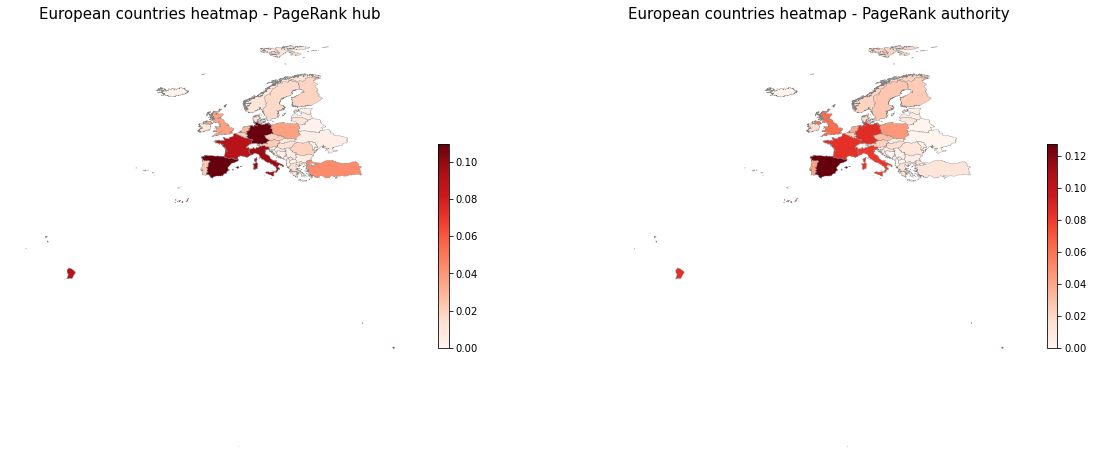

In [18]:
# deg_list = ['in degree', 'out degree', 'PageRank hub', 'PageRank autority']
#fig4, ax4 = plt.subplots(1,4, figsize=(20,15))
plt_list = ['PageRank hub', 'PageRank authority']
fig4, ax4 = plt.subplots(1,2, figsize=(20,15))

for i in range(len(plt_list)):
    european_df.plot(column=plt_list[i], ax=ax4[i], edgecolor='0.5', linewidth=0.3, cmap='Reds')
    sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=european_df[plt_list[i]].min(), 
                                              vmax=european_df[plt_list[i]].max()), cmap='Reds')
    ax4[i].axis('off')
    fig4.colorbar(sm, ax=ax4[i], shrink=0.25)
    ax4[i].set_title('European countries heatmap - ' + plt_list[i], fontsize=15)

# ax4 = np.reshape(ax4, (2,2))
# plt.savefig('eu_pagerank.png')

## Erasmus exchanges vs total students enrolled per country

In [19]:
# dataset containing for each european university the students enrolled in ISCED 5-7 (tertiary education and master degree)
isced57_df = pd.read_csv("eter-export-2016_loc.csv", delimiter=';', on_bad_lines='skip')
isced57_df.dropna(inplace=True)
for index in range(len(isced57_df['Institution Name'])):
    if isced57_df.iat[index,0] != isced57_df.iat[index,0].upper():
        isced57_df.iat[index,0] = isced57_df.iat[index,0].upper()


        
# dropping all the values having too many numbers after comma
mask = isced57_df['Total students enrolled ISCED 5-7'].str.contains(',', na=False)
isced57_df = isced57_df[~mask]

# dropping rows with undefined values
isced57_df = isced57_df[~isced57_df['Total students enrolled ISCED 5-7'].isin(['m','a','c','xr','s'])]

# changing country codes accordingly to european_df ones
isced57_df['Country Code'][isced57_df['Country Code'] == 'GR'] = 'EL'

isced57_df['Total students enrolled ISCED 5-7'] = isced57_df['Total students enrolled ISCED 5-7'].astype(float)
isced57_df['Total students enrolled ISCED 5-7'] = isced57_df['Total students enrolled ISCED 5-7'].round()
# count total number of enrolled students for each country
isced57_df = isced57_df.groupby(['Country Code'])['Total students enrolled ISCED 5-7'].sum().reset_index()

european_df_w = pd.merge(left=isced57_df, right=european_df, how='right', left_on='Country Code', right_on='iso2_code')
european_df_w = gpd.GeoDataFrame(european_df_w, geometry = 'geometry')

print('Top 10 countries for students enrollment')
display(european_df_w[['country', 'Total students enrolled ISCED 5-7']].sort_values('Total students enrolled ISCED 5-7',
                                                                                    ascending=False).head(10))

Top 10 countries for students enrollment


,country,Total students enrolled ISCED 5-7
31,Turkey,7107650.0
24,Germany,2625241.0
11,United Kingdom,2263020.0
28,Italy,1797986.0
9,Spain,1491419.0
26,Poland,1418588.0
12,Netherlands,720583.0
25,Greece,704969.0
20,Sweden,438578.0
4,Portugal,323467.0


In [20]:
european_df_w['weight_pr_hub'] = european_df_w['PageRank hub']/european_df_w['Total students enrolled ISCED 5-7']
european_df_w['weight_pr_aut'] = european_df_w['PageRank authority']/european_df_w['Total students enrolled ISCED 5-7']

# threshold set because some countries had too big values wrt the average
european_df_w.loc[european_df_w['weight_pr_hub'] > 2*10**(-7), 'weight_pr_hub'] = 2*10**(-7)
european_df_w.loc[european_df_w['weight_pr_aut'] > 2*10**(-7), 'weight_pr_aut'] = 2*10**(-7)
# maybe set better this thresholds

eu_w_copy = european_df_w.copy()
eu_w_copy.dropna(inplace = True)
# Countries ordered by weighted PageRank hub score
eu_w_copy.sort_values('weight_pr_hub', ascending=False, inplace=True)
eu_w_copy.reset_index(drop=True, inplace=True)
display(eu_w_copy[['country', 'weight_pr_hub']])
# Countries ordered by weighted PageRank authority score
eu_w_copy.sort_values('weight_pr_aut', ascending=False, inplace=True)
eu_w_copy.reset_index(drop=True, inplace=True)
display(eu_w_copy[['country', 'weight_pr_aut']])


,country,weight_pr_hub
0,Luxembourg,2.000000e-07
1,Liechtenstein,2.000000e-07
2,Malta,1.615408e-07
3,Romania,1.417199e-07
4,Slovenia,1.026944e-07
5,Lithuania,1.007646e-07
6,Estonia,8.790258e-08
7,Belgium,8.692329e-08
8,Slovakia,7.897599e-08
9,Spain,7.345657e-08


,country,weight_pr_aut
0,Luxembourg,2.000000e-07
1,Malta,2.000000e-07
2,Liechtenstein,2.000000e-07
3,Slovenia,1.755364e-07
4,Portugal,1.335447e-07
5,Estonia,1.275060e-07
6,Belgium,1.089761e-07
7,Czechia,1.052977e-07
8,Finland,9.151670e-08
9,Lithuania,8.724522e-08


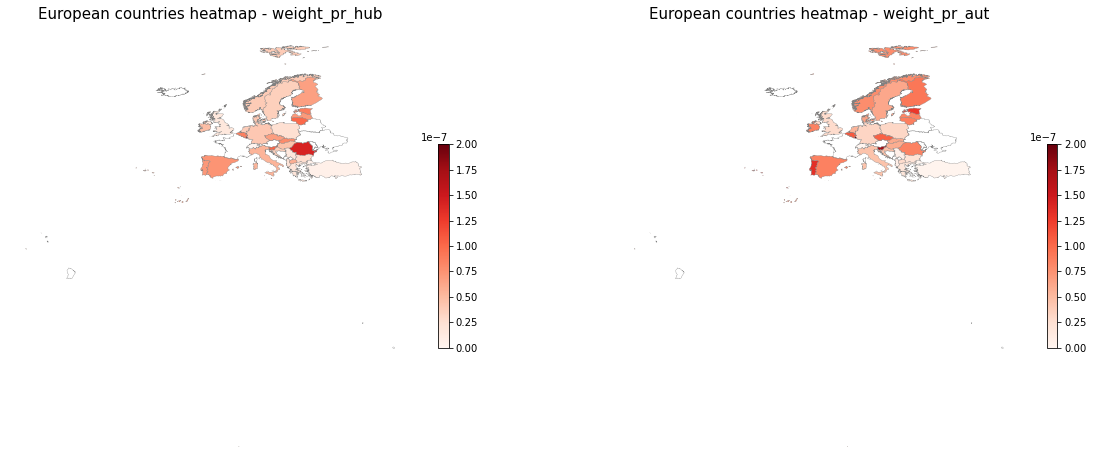

In [21]:
fig7, ax7 = plt.subplots(1,2, figsize=(20,15))
plt_list = ['weight_pr_hub', 'weight_pr_aut']
for i in range(len(plt_list)):
    # european_df_w.drop(european_df_w[plt_list[i]].idxmax(), inplace=True)
    european_df_w.plot(column=plt_list[i], ax=ax7[i], edgecolor='0.5', linewidth=0.3, cmap='Reds')
    sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=european_df_w[plt_list[i]].min(), 
                                              vmax=european_df_w[plt_list[i]].max()), cmap='Reds')
    ax7[i].axis('off')
    fig7.colorbar(sm, ax=ax7[i], shrink=0.25)
    ax7[i].set_title('European countries heatmap - ' + plt_list[i], fontsize=15)
    
# plt.savefig('eu_pagerank_weight.png')

## GeoPlot for Communities

Text(0.5, 1.0, 'European countries - Commmunity')

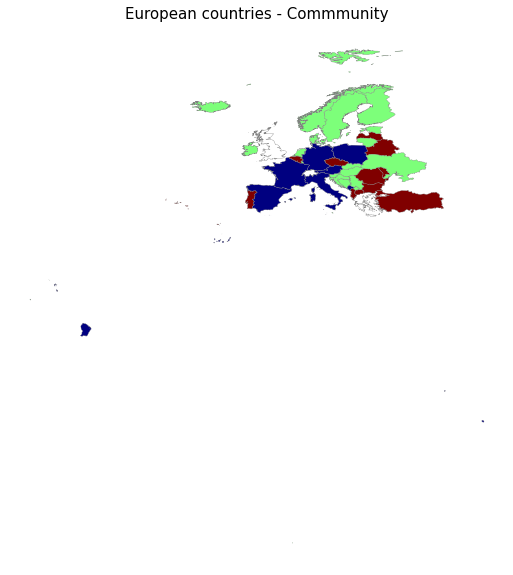

In [24]:
node_comm.loc[node_comm['Nodes'] == 'Moldova, Republic of', 'Nodes'] = 'Moldova'
node_comm.loc[node_comm['Nodes'] == 'North Macedonia', 'Nodes'] = 'Macedonia'
node_comm.loc[node_comm['Nodes'] == 'XK', 'Nodes'] = 'Kosovo'

eu_communities = european_df.copy()
eu_communities['Community'] = node_comm[node_comm['Nodes'].isin(european_countries)]['Community']

fig5, ax5 = plt.subplots(figsize=(10,10))
eu_communities.plot(column='Community', ax=ax5, edgecolor='0.5', linewidth=0.3, cmap='jet')
ax5.axis('off')
ax5.set_title('European countries - Commmunity', fontsize=15)

# plt.savefig('eu_community.png')